## Set-up

In [1]:
import tifffile
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from pathlib import Path
import gc
from matplotlib import colormaps as cm

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import utils
import track

2024-03-18 08:13:25.775043: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 08:13:25.803721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 08:13:25.803751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 08:13:25.805100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 08:13:25.810390: I tensorflow/core/platform/cpu_feature_guar

### Hyper parameters

In [2]:
loadstar_weight_name = "Loadstar_EV_24462"
magik_weight_name = "MAGIK_MP_MPN"

# Experiment parameters
tiff_path = r'/home/gideon/Documents/PhD/Projects/KAW/data_from_VE/Experiment-16031.tif'
output_path = r'/home/gideon/Documents/PhD/Projects/KAW/output'
pages_batch_size = 2
channel_width = 300

# Loadstar parameters
alpha = 0.999
cutoff = 1e-2

# MAGIK parameters
radius = 0.08
traj_min = 6
n_frames = 7

# Calculated parameters
pixel_size_x = x_resolution / width
pixel_size_y = y_resolution / height
channel_width_norm = channel_width / x_resolution
channel_width_ratio = radius / channel_width_norm

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

loadstar, magik = utils.load_models(loadstar_weight_name, magik_weight_name)

Num GPUs Available:  0


### Extract metadata

In [98]:
tiffpage = tifffile.TiffFile(tiff_path).pages[100]
for tag in tiffpage.tags.values():
    print(tag.name, tag.value)

NewSubfileType 0
ImageWidth 1254
ImageLength 1254
BitsPerSample 16
Compression 1
PhotometricInterpretation 1
ImageDescription ImageJ=1.54f
images=220
frames=220
unit=micron
finterval=0.45014611872146115
loop=false
min=254.0
max=255.0
StripOffsets (314522251,)
SamplesPerPixel 1
RowsPerStrip 1254
StripByteCounts (3145032,)
XResolution (9090909, 1000000)
YResolution (9090909, 1000000)
ResolutionUnit 1


In [72]:
width = tiffpage.tags.get('ImageWidth').value
hight = tiffpage.tags.get('ImageLength').value
x_resolution = tiffpage.tags.get('XResolution').value
y_resolution = tiffpage.tags.get('YResolution').value
print(hight, width)

1254 1254


## Detect

In [13]:
detections  = utils.detect(tiff_path, loadstar, pages_batch_size, alpha, cutoff)
utils.save_detections(detections, "../../output/detections-2.csv", full=True)

  0%|          | 0/110 [00:00<?, ?it/s]

100%|██████████| 110/110 [01:11<00:00,  1.55it/s]


## Track

In [14]:
tracks = utils.warp_xaxis(detections, channel_width_ratio)
tracks = track.predict_trajectories(magik, detections, radius, n_frames, traj_min)
tracks['x'] *= width/channel_width_ratio
tracks['y'] *= hight
track.save_trajectories(tracks, "../../output/tracks.csv")

100%|██████████| 1/1 [00:04<00:00,  4.35s/it]
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  d.loc[
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  alpha = 0.1 + d_alpha * int(solutions[i : i + 1]["frame_y"])
/home/gideon/Documents/PhD/Projects/KAW/.venv/lib/python3.11/site-packages/deeptrack/models/gnns/utils.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if not (str(int(solutions[i : i + 1]["node_x"])

In [15]:
tracks.head()

#for t in tracks['entity'].unique():
#    plt.figure()
#    plt.plot(tracks[tracks['entity'] == t]['x'], tracks[tracks['entity'] == t]['y'])
#    plt.title(f"Trajectory {t}")
#    plt.show()
#    plt.close()

,frame,y,x,entity
3,0.0,102.858891,1238.447820,1.0
4,0.0,155.372118,716.217935,2.0
5,0.0,251.583230,437.695392,3.0
8,0.0,303.690400,1107.441405,4.0
9,0.0,306.098453,437.798958,9.0


### Plot track (will be moved)

  6%|▌         | 28/499 [00:40<11:19,  1.44s/it]


KeyboardInterrupt: 

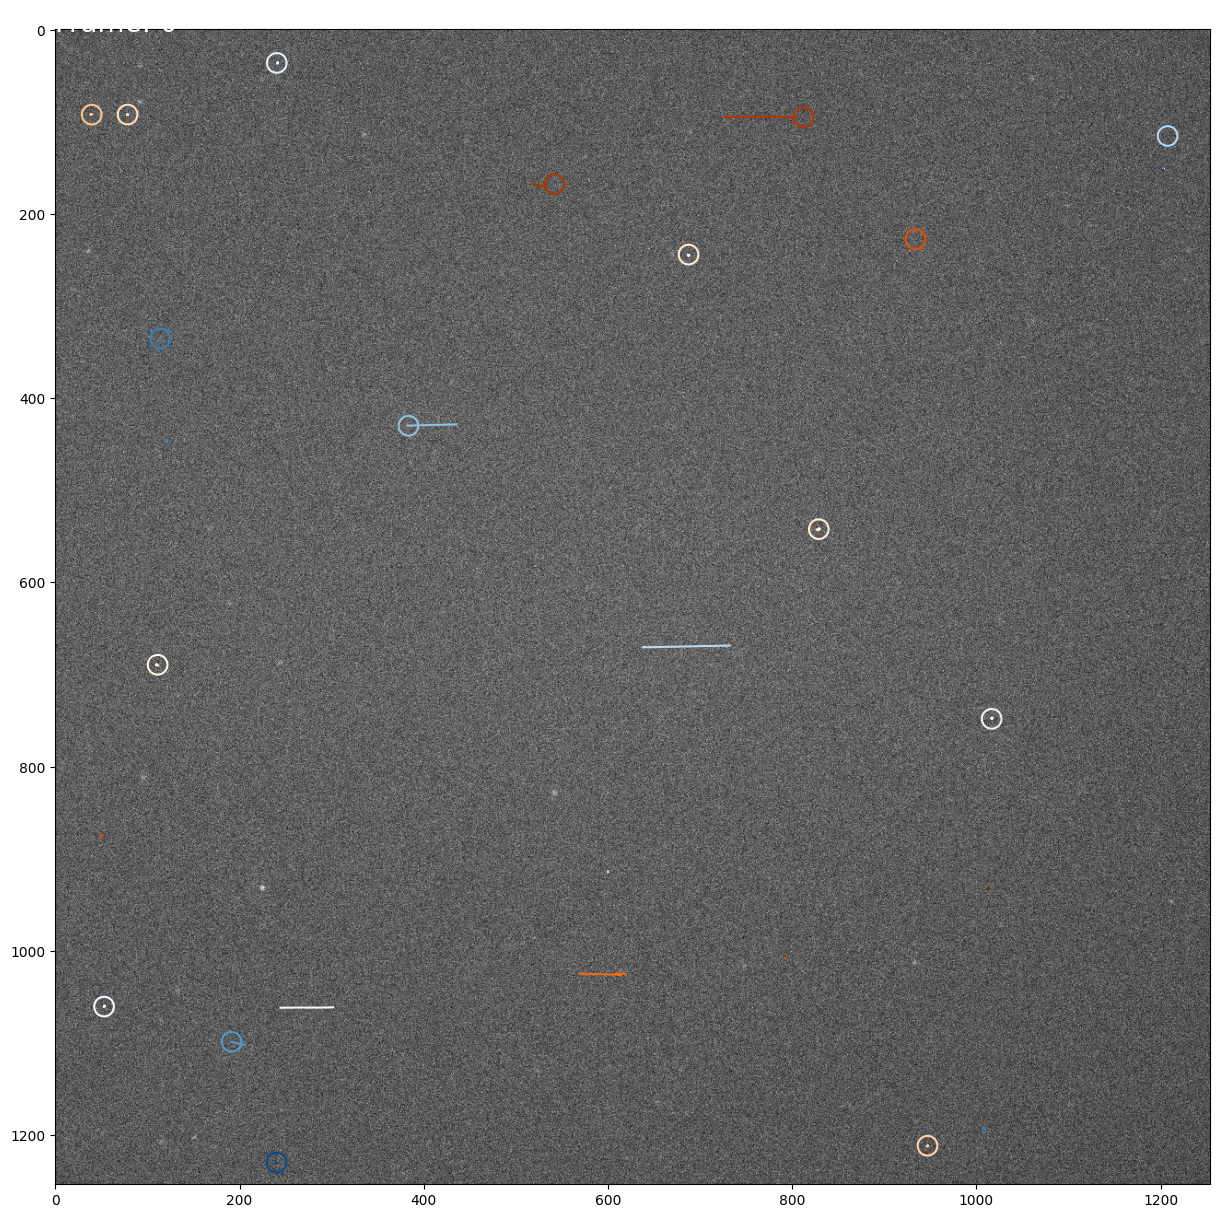

In [7]:
import matplotlib.patches as patches

file = tifffile.TiffFile(Path(tiff_path))
n_pages = len(file.pages)

top = cm.get_cmap("Oranges_r")
bottom = cm.get_cmap("Blues_r")

colors = np.vstack(
    (
        top(np.linspace(0, 1, int(np.ceil(tracks['entity'].max() / 2)))),
        bottom(np.linspace(0, 1, int(np.ceil(tracks['entity'].max() / 2)))),
    )
)
np.random.shuffle(colors)

for i in tqdm(range(int(tracks['frame'].max()//pages_batch_size))):
    pages = file.pages[i*pages_batch_size:min((i+1)*pages_batch_size, n_pages-1)]
    frames = np.array([page.asarray() for page in pages])
    frames = frames.astype(np.float32)

    # Plot
    for f, image in enumerate(frames):
        plt.figure(figsize=(15, 15))
        plt.imshow(image, cmap='gray')
        #rect = patches.Rectangle((5, 5), 121-5, 75-5, linewidth=1, edgecolor='r', facecolor='none')
        #plt.gca().add_patch(rect)
        plt.text(0, 2, "Frame: " + str(f), fontsize=20, c="white")

        detections = tracks[(tracks['frame'] == i*pages_batch_size + f)]
        trail = tracks[(tracks['frame'] < i*pages_batch_size + f) & (tracks['frame'] >= i*pages_batch_size + f - 10)]
            #detections = nodes[t][(nodes[t, 0] <= i*pages_batch_size + f) & (nodes[t, 0] >= i*pages_batch_size + f - 10), :]

            #if (len(detections) == 0) or (np.max(nodes[t, 0]) < f):
            #    continue
        for t in trail['entity'].unique():
            print(t)
            entity_trail = trail[trail['entity'] == t]
            plt.plot(entity_trail['x'], entity_trail['y'], color=colors[int(t)], linewidth=1.5)
        plt.scatter(detections['x'], detections['y'], linewidths=1.5, color = colors[detections['entity'].astype(int)], marker='o', s=200, facecolors='none')
        
        plt.savefig(f"../../output/trajected_images/fig_{str(i*pages_batch_size + f).zfill(4)}.png")
        plt.clf()
        plt.close('all')
        gc.collect()
    if i > 50:
        break

## Further analyze the tracks

### Remove still particles

In [59]:
tracks = track.load_trajectories("../../output/tracks.csv")

still_cuttoff = 40

print(f'Number of objects before: {len(tracks.entity.unique())}')

tracks_stills_removed = utils.remove_still_objects(tracks, still_cuttoff)

print(f'Number of objects after: {len(tracks_stills_removed.entity.unique())}')

Number of objects before: 111
Number of objects after: 79


In [66]:
import importlib
importlib.reload(track)

track.plot_trajectories(tracks_stills_removed, tiff_path, output_path, pages_batch_size, stop=4)

100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


### Track length and distance

In [67]:
tracks = tracks_stills_removed

tracks = track.distance_traveled(tracks)
tracks.head(20)

,frame,y,x,entity,delta_y,delta_x,traveled_y,traveled_x
3,0.0,303.690400,1107.441405,4.0,0.000000,0.000000,0.000000,0.000000
5,0.0,523.794483,611.392090,5.0,0.000000,0.000000,0.000000,0.000000
6,0.0,594.190313,102.457544,6.0,0.000000,0.000000,0.000000,0.000000
7,0.0,601.296433,943.469259,7.0,0.000000,0.000000,0.000000,0.000000
8,0.0,1002.529709,962.660706,8.0,0.000000,0.000000,0.000000,0.000000
12,1.0,309.889499,1107.882456,4.0,6.199099,0.441051,6.199099,0.441051
13,1.0,555.567131,610.950322,5.0,31.772649,0.441768,31.772649,0.441768
14,1.0,597.120473,102.117294,6.0,2.930160,0.340251,2.930160,0.340251
15,1.0,611.973010,943.427821,7.0,10.676577,0.041438,10.676577,0.041438
16,1.0,983.432111,962.376319,8.0,19.097598,0.284387,19.097598,0.284387
